In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python                      # install opencv

In [3]:
# Tools to use

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


In [4]:
test_folder = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A00_v2" # Testing purposes
image_folder1 = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A01_v2" # Training
image_folder2 = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A02_v2" # Validation
image_folder3 = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A03_v2" # Training
image_folder4 = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A04_v2" # Training


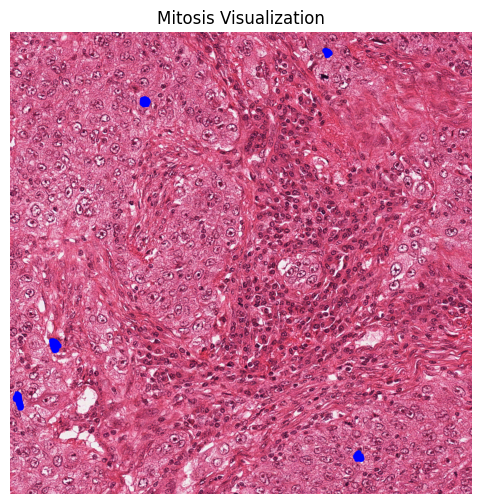

In [5]:
#---------------------------  S T A G E 1  ---------------------------

csv_path = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A00_v2/A00_01.csv"
image_path = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A00_v2/A00_01.bmp"


# Load image
image = cv2.imread(image_path)

# Read and clean CSV data
with open(csv_path, "r") as file:
    content = file.read().strip()  # Read all and remove trailing spaces/newlines

# Clean data by replacing spaces and newlines with commas
content = content.replace("\n", "").replace("\r", "")

# Convert to list of integers
numbers = list(map(int, content.split(',')))  # Split and convert to integers

# Reshape into (N, 2) coordinate pairs
mitosis_coords = np.array(numbers).reshape(-1, 2)

# Function to visualize mitosis locations
def visualize_mitosis(image, mitosis_coords):
    img_copy = image.copy()

    for (x, y) in mitosis_coords:
        cv2.circle(img_copy, (x, y), 10, (255, 0, 0), -1)  # Blue dots

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title("Mitosis Visualization")
    plt.axis("off")
    plt.show()

# Visualize the mitosis locations
visualize_mitosis(image, mitosis_coords)

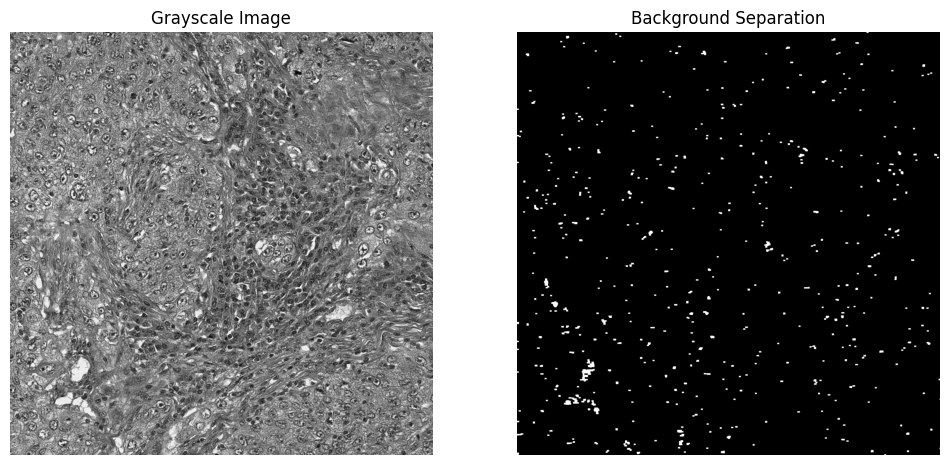

In [11]:
#---------------------------  S T A G E 2  ---------------------------


# Converting the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Applying Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# **Applying Adaptive Gaussian Thresholding**
binary_mask = cv2.adaptiveThreshold(
    blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 11, 2
)

# **Applying Morphological Operations for Noise Reduction**
kernel = np.ones((3, 4), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=3)  # Fill holes
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)  # Remove small noise

# **Inverting the mask**
binary_mask = cv2.bitwise_not(binary_mask)

# Displaying the grayscale image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")

# Displaying the improved binary mask
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray")
plt.title("Background Separation")
plt.axis("off")

plt.show()


Ground Truth Coordinates:
[[ 158  239]
 [ 159  239]
 [ 160  239]
 ...
 [1292  381]
 [1293  382]
 [1293  383]]
Total keypoints detected: 7989
Combined descriptor shape: (7989, 128)


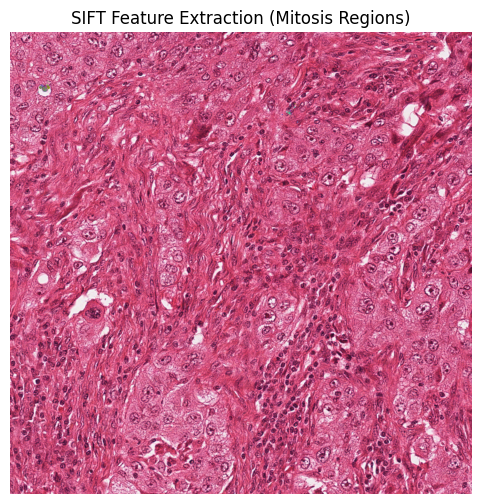

In [12]:
#---------------------------  S T A G E 3  ---------------------------


import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Function to load mitosis coordinates from a CSV file.
# -------------------------------
def load_mitosis_coords(csv_path):

    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            content = f.read()
        # Remove newline characters and trailing commas/spaces.
        content = content.replace("\n", "").replace("\r", "").strip().rstrip(',')
        # Split the string into parts.
        parts = [p for p in content.split(",") if p.strip()]
        # Convert parts to integers.
        numbers = list(map(int, parts))
        # If there's an odd number of values, drop the last one.
        if len(numbers) % 2 != 0:
            print(f"Warning: {csv_path} has an odd number of values; dropping the last value.")
            numbers = numbers[:-1]
        coords = np.array(numbers, dtype=int).reshape(-1, 2)
        return coords
    except Exception as e:
        print(f"Error loading {csv_path}: {e}")
        return np.array([])


# Stage 3: SIFT Feature Extraction around Ground-Truth Coordinates


# Example image
image_path = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A00_v2/A00_03.bmp"
csv_path   = image_path.replace(".bmp", ".csv")

# Load the image.
image = cv2.imread(image_path)
if image is None:
    print("Error: Test image not loaded. Check the file path and format.")
else:
    # Convert image to grayscale.
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load ground-truth mitosis coordinates.
    mitosis_coords = load_mitosis_coords(csv_path)
    print("Ground Truth Coordinates:")
    print(mitosis_coords)

    # Initialize SIFT with specified parameters.
    sift = cv2.SIFT_create(contrastThreshold=0.12, edgeThreshold=20)

    keypoints_all = []
    descriptors_all = []
    crop_size = 20  # Define how large the patch around each coordinate should be.

    # Loop over each ground-truth coordinate.
    for (x, y) in mitosis_coords:
        # Get image dimensions.
        h, w = gray_image.shape[:2]
        # Compute bounding box coordinates around (x, y) with crop_size.
        x1 = max(0, x - crop_size)
        y1 = max(0, y - crop_size)
        x2 = min(w, x + crop_size)
        y2 = min(h, y + crop_size)

        # Skip if bounding box is invalid.
        if x1 >= x2 or y1 >= y2:
            continue

        # Crop the patch from the grayscale image.
        mitosis_patch = gray_image[y1:y2, x1:x2]

        # Skip if the patch is empty.
        if mitosis_patch.size == 0:
            continue

        # Ensure the patch is 8-bit unsigned.
        if mitosis_patch.dtype != np.uint8:
            mitosis_patch = mitosis_patch.astype(np.uint8)

        # Extract SIFT keypoints and descriptors from the patch.
        keypoints, descriptors = sift.detectAndCompute(mitosis_patch, None)

        # If no keypoints were found, skip this patch.
        if keypoints is None or len(keypoints) == 0:
            continue

        # Limit the number of keypoints per patch to 40 (strongest ones).
        keypoints = sorted(keypoints, key=lambda k: -k.response)[:40]

        # Adjust keypoint coordinates to the global image coordinates.
        for kp in keypoints:
            kp.pt = (kp.pt[0] + x1, kp.pt[1] + y1)

        keypoints_all.extend(keypoints)
        if descriptors is not None:
            # Limit descriptors to match the number of keypoints and store.
            descriptors_all.append(descriptors[:40])

    # Combine all descriptors from each patch into one array.
    if descriptors_all:
        descriptors_all = np.vstack(descriptors_all)
    else:
        descriptors_all = np.array([])

    print("Total keypoints detected:", len(keypoints_all))
    print("Combined descriptor shape:", descriptors_all.shape)

    # Draw the keypoints on the original image for visualization.
    sift_image = cv2.drawKeypoints(image, keypoints_all, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB))
    plt.title("SIFT Feature Extraction (Mitosis Regions)")
    plt.axis("off")
    plt.show()


In [13]:
#---------------------------  S T A G E 4  ---------------------------


import cv2
import numpy as np
import os

def load_mitosis_coords(csv_path):

    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            content = f.read()

        content = content.replace("\n", "").replace("\r", "").strip().rstrip(',')
        parts = [p for p in content.split(',') if p.strip()]
        numbers = list(map(int, parts))
        if len(numbers) % 2 != 0:
            print(f"Warning: {csv_path} has an odd number of values ({len(numbers)}); dropping the last value.")
            numbers = numbers[:-1]

        if len(numbers) % 2 != 0:
            return np.array([])

        coords = np.array(numbers, dtype=int).reshape(-1, 2)
        return coords
    except Exception as e:
        print(f"Error loading {csv_path}: {e}")
        return np.array([])

def background_separation(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    _, binary_mask = cv2.threshold(
        blurred, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    return binary_mask

def find_cells(binary_mask, min_area=20):

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    bboxes = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area < min_area:
            continue
        bboxes.append((x, y, w, h))
    return bboxes

def is_mitosis(bbox, mitosis_coords):

    x, y, w, h = bbox
    x2, y2 = x + w, y + h
    for (mx, my) in mitosis_coords:
        if x <= mx <= x2 and y <= my <= y2:
            return 1
    return 0


In [14]:
from sklearn.cluster import MiniBatchKMeans

def extract_sift_descriptors(image, bbox, max_per_patch=50):
    """
    Extract up to max_per_patch SIFT descriptors from the bounding box region.
    """
    x, y, w, h = bbox
    patch = image[y:y+h, x:x+w]
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY) if patch.ndim == 3 else patch

    sift = cv2.SIFT_create(contrastThreshold=0.09, edgeThreshold=20)
    keypoints, descriptors = sift.detectAndCompute(gray_patch, None)
    if descriptors is None or descriptors.size == 0:
        return np.array([])
    if descriptors.shape[0] > max_per_patch:
        descriptors = descriptors[:max_per_patch]
    return descriptors

def build_vocabulary(train_folders, K=100):
    all_descriptors = []
    for folder in train_folders:
        for file in os.listdir(folder):
            if file.endswith(".bmp"):
                bmp_path = os.path.join(folder, file)
                image = cv2.imread(bmp_path)
                if image is None:
                    continue
                # Stage 2: background separation
                binary_mask = background_separation(image)
                bboxes = find_cells(binary_mask)
                # Extract descriptors from each bounding box
                for bbox in bboxes:
                    desc = extract_sift_descriptors(image, bbox)
                    if desc.size > 0:
                        all_descriptors.append(desc)
    if all_descriptors:
        all_descriptors = np.vstack(all_descriptors)
    else:
        all_descriptors = np.array([])
    print("Total descriptors for vocabulary:", all_descriptors.shape)

    kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=100).fit(all_descriptors)
    return kmeans

def compute_bovw_histogram(descriptors, kmeans, K):
    """
    Convert a set of local descriptors into a histogram of K visual words.
    """
    if descriptors.size == 0:
        return np.zeros(K)
    labels = kmeans.predict(descriptors)
    hist = np.bincount(labels, minlength=K)
    norm = np.linalg.norm(hist)
    return hist / norm if norm > 0 else hist


In [15]:
def build_dataset(folder_paths, kmeans, K=100):
    X, y = [], []
    for folder in folder_paths:
        for file in os.listdir(folder):
            if file.endswith(".bmp"):
                bmp_path = os.path.join(folder, file)
                csv_path = bmp_path.replace(".bmp", ".csv")
                image = cv2.imread(bmp_path)
                if image is None:
                    continue

                true_coords = load_mitosis_coords(csv_path)
                binary_mask = background_separation(image)
                bboxes = find_cells(binary_mask)

                for bbox in bboxes:
                    label = is_mitosis(bbox, true_coords)
                    desc = extract_sift_descriptors(image, bbox)
                    bovw_hist = compute_bovw_histogram(desc, kmeans, K)
                    X.append(bovw_hist)
                    y.append(label)
    return np.array(X), np.array(y)


In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Example Stage 4 pipeline
def stage4_pipeline():
    # 1) Define training folders
    train_folders = [
        "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A01_v2",
        "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A03_v2",
        "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A04_v2"
    ]

    # 2) Build a BoVW vocabulary from training images
    K = 100
    kmeans = build_vocabulary(train_folders, K=K)
    print("Vocabulary built with K =", K)

    # 3) Build the training dataset
    X_train, y_train = build_dataset(train_folders, kmeans, K=K)
    print("Training dataset shape:", X_train.shape, y_train.shape)
    print("Positives:", np.sum(y_train==1))
    print("Negatives:", np.sum(y_train==0))

    # 4) Train an SVM (with or without class weighting)
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
    svc = SVC(class_weight='balanced', random_state=42)
    grid = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', verbose=1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print("Best SVM parameters:", grid.best_params_)

    # Evaluate on training set
    train_preds = best_model.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)
    train_f1  = f1_score(y_train, train_preds, average='binary')
    print("Training Accuracy:", train_acc)
    print("Training F1 Score:", train_f1)
    print("Training Confusion Matrix:\n", confusion_matrix(y_train, train_preds))
    print("Training Classification Report:\n", classification_report(y_train, train_preds))

    # 5) Validation (A02)
    val_folders = ["/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A02_v2"]
    X_val, y_val = build_dataset(val_folders, kmeans, K=K)
    val_preds = best_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_preds)
    val_f1  = f1_score(y_val, val_preds, average='binary')
    print("Validation Accuracy:", val_acc)
    print("Validation F1 Score:", val_f1)
    print("Validation Confusion Matrix:\n", confusion_matrix(y_val, val_preds))
    print("Validation Classification Report:\n", classification_report(y_val, val_preds))

    return best_model, kmeans

# Example usage:
best_model, kmeans = stage4_pipeline()


Total descriptors for vocabulary: (73622, 128)
Vocabulary built with K = 100
Training dataset shape: (20994, 100) (20994,)
Positives: 91
Negatives: 20903
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best SVM parameters: {'C': 0.1, 'kernel': 'rbf'}
Training Accuracy: 0.9921882442602649
Training F1 Score: 0.4906832298136646
Training Confusion Matrix:
 [[20751   152]
 [   12    79]]
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     20903
           1       0.34      0.87      0.49        91

    accuracy                           0.99     20994
   macro avg       0.67      0.93      0.74     20994
weighted avg       1.00      0.99      0.99     20994

Validation Accuracy: 0.9852637783672267
Validation F1 Score: 0.05660377358490566
Validation Confusion Matrix:
 [[6683   74]
 [  26    3]]
Validation Classification Report:
               precision    recall  f1-score   support

           0  

In [24]:
def predict_mitosis_coords(image, model, kmeans, K):

    # 1) Example background separation
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 2) Find bounding boxes
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    bboxes = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area < 20:  # skip small noise
            continue
        bboxes.append((x, y, w, h))

    # 3) For each box, extract features
    pred_coords = []
    for (x, y, w, h) in bboxes:
        patch = image[y:y+h, x:x+w]
        if patch.size == 0:
            continue

        # Example: SIFT descriptor extraction
        gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(gray_patch, None)
        if descriptors is None or descriptors.size == 0:
            continue

        # Minimal BoVW histogram
        hist = compute_bovw_histogram(descriptors, kmeans, K)

        # Classify
        pred_label = model.predict([hist])[0]
        if pred_label == 1:
            # bounding box center
            cx = x + w // 2
            cy = y + h // 2
            pred_coords.append((cx, cy))

    return np.array(pred_coords, dtype=int)


def compute_iou(true_coords, pred_coords, max_dist=50):

    true_used = set()
    pred_used = set()

    for i, (px, py) in enumerate(pred_coords):
        best_j = None
        best_dist = float('inf')
        for j, (tx, ty) in enumerate(true_coords):
            if j in true_used:
                continue
            dist = np.hypot(px - tx, py - ty)
            if dist < best_dist:
                best_dist = dist
                best_j = j
        if best_j is not None and best_dist <= max_dist:
            pred_used.add(i)
            true_used.add(best_j)

    intersection = len(pred_used)
    union = len(true_coords) + len(pred_coords) - intersection
    return intersection / union if union > 0 else 0


def compute_bovw_histogram(descriptors, kmeans, K):

    if descriptors.size == 0:
        return np.zeros(K)
    labels = kmeans.predict(descriptors)
    hist = np.bincount(labels, minlength=K)
    norm = np.linalg.norm(hist)
    return hist / norm if norm > 0 else hist

# Example usage: compute IoU for test images

test_folder = "/content/drive/MyDrive/EE417_HW1/mitosis_dataset_scanner_A/scanner_A/A00_v2"
iou_scores = []

for file in os.listdir(test_folder):
    if file.endswith(".bmp"):
        bmp_path = os.path.join(test_folder, file)
        csv_path = bmp_path.replace(".bmp", ".csv")

        # Load test image
        image = cv2.imread(bmp_path)
        if image is None:
            print(f"Error loading {bmp_path}")
            continue

        # Load ground-truth coordinates
        true_coords = load_mitosis_coords(csv_path)
        if true_coords.size == 0:
            print(f"Warning: No valid coords for {csv_path}")
            continue

        # Predict
        pred_coords = predict_mitosis_coords(image, best_model, kmeans, 100)

        # IoU
        iou = compute_iou(true_coords, pred_coords, max_dist=50)
        iou_scores.append(iou)
        print(f"{file} IoU: {iou:.3f}")

if iou_scores:
    mean_iou = np.mean(iou_scores)
    print("\nFinal Mean IoU on Test Set:", mean_iou)


A00_01.bmp IoU: 0.000
A00_03.bmp IoU: 0.000
A00_06.bmp IoU: 0.000
A00_05.bmp IoU: 0.000
A00_04.bmp IoU: 0.000
A00_02.bmp IoU: 0.000
A00_07.bmp IoU: 0.000
A00_09.bmp IoU: 0.000

Final Mean IoU on Test Set: 0.0
